In [14]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

In [3]:
data = pd.read_excel("./2016cityandcountyenergyprofiles(1).xlsb",sheet_name='County',skiprows=4)

In [4]:
col_info = pd.read_excel("./2016cityandcountyenergyprofiles(1).xlsb",sheet_name='County',nrows=4)

In [5]:
#use this to tell if its residential, industrial or other 
column_identity = col_info.iloc[[0,1],:]

In [6]:
def make_name(s1,s2): 
    out_name = ""
    if not (pd.isna(s1) and pd.isna(s2)): 
        out_name = "_".join( [e for e in [s1,s2] if not pd.isna(e)])
    return out_name

In [7]:
#iterate through all the column names and make them be "residential_consumpition","industrial_consumption" etc 
name_cats = list() 
for col_names in col_info:
    col = col_info[col_names] 
    n1 = col.iloc[0] 
    n2 = col.iloc[1] 
    new_name = make_name(n1,n2)
    name_cats.append(new_name)

In [8]:
#define the actual new neames
new_name = [ f"{a}_{b}" if a  else b for a,b in zip(name_cats,data.keys().to_list()) ] 

In [9]:
#replace the column names 
data.columns = new_name

In [11]:
def conv_to_fips(row): 
    s = str(row)
    if len(s)<=4: 
        return "0500000US0" + s
    else: 
        return "0500000US" + s

In [17]:
#just visualizing some features out of curiosity 

<AxesSubplot:xlabel='doe_climate_zone', ylabel='Residential_Electricity_GHG emissions mtons CO2e'>

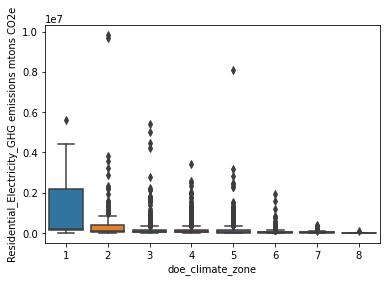

In [18]:
cat_col = "doe_climate_zone"
emision_col = 'Residential_Electricity_GHG emissions mtons CO2e'
sns.boxplot(data=data,x=cat_col,y=emision_col)

<AxesSubplot:xlabel='Residential_Electricity_GHG emissions mtons CO2e', ylabel='Count'>

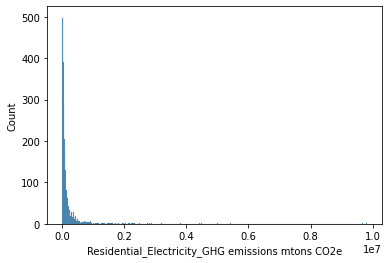

In [19]:
sns.histplot(data=data , x =emision_col) 

<AxesSubplot:xlabel='Residential_Electricity_GHG emissions mtons CO2e', ylabel='Count'>

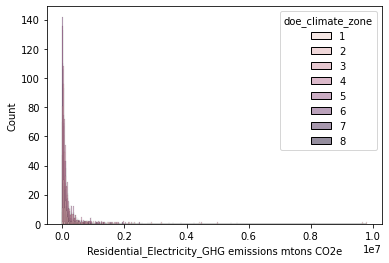

In [20]:
sns.histplot(data=data , x =emision_col,hue=cat_col) 

In [22]:
data[emision_col].describe() 
extra_lim = 1.477956e+05 + 1* 4.739903e+05

(0.0, 621785.9)

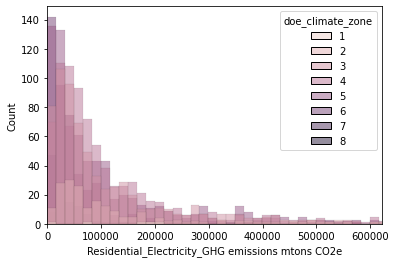

In [23]:
#constrain the data visualization range 
sns.histplot(data=data,x=emision_col,hue=cat_col) #TODO: use some other stackign feature 
plt.xlim([0,extra_lim])

In [42]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import r2_score , mean_squared_error 
import numpy as np 

In [26]:
#Define train test groupings
train,test =  train_test_split(data['state_id'].unique(),random_state=1996)
train_df, test_df =  data[data['state_id'].isin(train)].copy(),data[data['state_id'].isin(test)].copy()

In [27]:
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

In [30]:
cols = ['employment','population','Residential_Electricity_utility customers', 'Residential_occuped housing units','population', 'latitude','longitude', 'Industry_establishments']

In [31]:
tr_x =  train_df[cols].values
ts_x = train_df[cols].values

In [32]:
tr_y = train_df[emision_col].values.reshape((-1,1))
ts_y = train_df[emision_col].values.reshape((-1,1))

In [33]:
y_sc = MinMaxScaler()
tr_y_n = y_sc.fit_transform(tr_y) 
ts_y_n = y_sc.transform(ts_y)

In [34]:
sc = StandardScaler() 
tr_x_n = sc.fit_transform(tr_x) 
ts_x_n = sc.transform(tr_x)

In [39]:
model =Ridge()  
model.fit(tr_x_n,tr_y_n)

Ridge()

In [40]:
ts_out = model.predict(ts_x_n)
tr_out = model.predict(tr_x_n)

In [43]:
avg_pred = np.mean(tr_y_n)

In [51]:
tr_mse = mean_squared_error(tr_y_n,tr_out) 
ts_mse = mean_squared_error(ts_y_n,ts_out)

In [52]:
tr_mse_avg_pred = mean_squared_error(tr_y_n,np.ones(tr_y_n.shape)*avg_pred)
ts_mse_avg_pred = mean_squared_error(ts_y_n,np.ones(ts_y_n.shape)*avg_pred)

In [56]:
print(f"Train MSE: {tr_mse:0.4}  Test MSE: {ts_mse:0.4}  ")
print(f"Baseline Train  MSE: {tr_mse_avg_pred:0.4} Baseline Train MSE: {ts_mse_avg_pred:0.4} ") 


Train MSE: 0.0004489  Test MSE: 0.0004489  
Baseline Train  MSE: 0.00274 Baseline Train MSE: 0.00274 


In [57]:
r2_score(tr_y_n,tr_out)

0.836157659238039

In [58]:
r2_score(ts_y_n,ts_out)

0.836157659238039